# Classifying Names with a Character-Level RNN

This tutorial demonstrates the process of building a recurrent neural network (RNN) that accepts names, character by character, and predicts the language of each name. Through this exercise, learners will gain hands-on experience with several core concepts in machine learning and deep learning, specifically within the context of PyTorch, a leading deep learning framework.

## What is PyTorch?

PyTorch is an open-source machine learning library developed by Facebook's AI Research lab (FAIR). It provides a flexible and intuitive framework for building and training deep learning models. PyTorch is known for its dynamic computation graph that allows for more flexible model architecture, its ease of use in research and development, and its extensive ecosystem of tools and libraries.

## Learning Objectives

- Understand how to preprocess text data (names) and convert them into tensors that can be processed by neural networks.
- Learn how to design and implement a recurrent neural network layer by layer using PyTorch.
- Explore the sequential processing capabilities of RNNs and how they handle input data over time.
- Discover how PyTorch automates the tracking of gradients and updates network parameters during training.
- Use a confusion matrix to evaluate the performance of the RNN model and identify areas for improvement.

## Understanding the Value of Recurrent Neural Networks (RNNs)

Recurrent Neural Networks (RNNs) stand out in the neural network family due to their proficiency in handling sequential data. Unlike their counterparts, such as fully-connected or convolutional neural networks which require inputs of a fixed size, RNNs excel in dealing with inputs that vary in length. This characteristic makes them exceptionally suited for tasks involving streams of data, such as processing text one character at a time.

### The Case for RNNs in Language Prediction

Consider the task of determining the language origin of a name, for instance, "John" or "Rodrigo". Names vary significantly in length and structure, posing a challenge for neural network architectures that necessitate fixed-size inputs. While it's possible to adapt these models to handle variable-length inputs, RNNs offer a more natural and efficient solution.

RNNs process inputs sequentially, making them ideal for this scenario. They can take each character of a name, one after the other, and use the information accumulated from previously seen characters to inform the prediction of the name's language origin. This ability to "remember" information from earlier in the sequence is what gives RNNs their edge in tasks involving variable-length sequences, making them a superior choice for our language prediction example.

### Preprocessing Data for RNN

Before diving into the construction of our Recurrent Neural Network, it's crucial to prepare our data. Given that our dataset comprises names from various languages, which may include accented characters, our first step involves normalizing these names. This normalization includes converting all characters to ASCII, removing any accents in the process. Simplifying the dataset in this manner reduces the complexity for our RNN, allowing it to focus on a smaller set of characters.

### Converting Unicode to ASCII

To handle names with accented letters, we utilize a function `unicode_to_ascii` that transforms a string containing Unicode characters into one that consists solely of ASCII characters. This simplification step is particularly helpful in standardizing the data and reducing the character set our model needs to learn.

In [1]:
# Import necessary libraries for data processing
import unicodedata
import string

# Define a string of valid characters including ASCII letters and some punctuation
valid_chars = string.ascii_letters + " .,;'"
n_chars = len(valid_chars)  # Count of valid characters, useful for later model configurations

def unicode_to_ascii(string):
    """Convert a Unicode string into ASCII characters, removing accents."""
    # Normalize the string using NFD, then filter out non-ASCII and non-valid characters
    return "".join(
        c for c in unicodedata.normalize("NFD", string)
        if unicodedata.category(c) != "Mn" and c in valid_chars
    )

### What is Unicode Normalization?

Unicode normalization is a process for standardizing Unicode text into a consistent format, which is crucial for text processing and comparison tasks. Diacritics, or accent marks, are a common feature in many languages, providing phonetic distinction to letters. However, these can introduce complexity in text processing, especially in natural language processing (NLP) tasks.

There are several forms of Unicode normalization, but here we'll focus on Normal Form D (NFD), which stands for Canonical Decomposition. NFD breaks down characters into their base characters and separate diacritic marks. This decomposition is particularly useful in NLP and text processing tasks because it allows for a more straightforward comparison of strings that may visually appear similar but are encoded differently in Unicode.

In [2]:
unicode_to_ascii("Girão")

'Girao'

In [3]:
unicode_to_ascii("Ślusàrski")

'Slusarski'

### Finding Data Files

First, we identify the text files containing our dataset. This is achieved using the `pathlib` library, which provides an efficient method to glob through the directory containing our names dataset.


In [4]:
# Import pathlib for efficient file system navigation
import pathlib

def find_files(path):
    """Return a list of all text files in the given directory."""
    # Use glob to find all '.txt' files in the specified path
    return pathlib.Path(path).glob("*.txt")

print(len(list(find_files("names"))))  # We have 18 files for 18 languages


18


### Processing and Organizing Names by Language

After identifying the files, we process each to normalize the names contained within and organize these names by their respective languages. This organization is crucial for training our RNN, as it allows for language-specific name processing.


In [5]:
def process_names_file(filename):
    """Process each names file, normalizing names to ASCII."""
    with open(filename) as f:
        # Read each line, strip whitespace, normalize to ASCII, and return as a list
        return [unicode_to_ascii(line.strip()) for line in f]

# Dictionary to hold names organized by language
names_by_language = {
    filename.stem: process_names_file(filename)  # Use file stem as the language key
    for filename in find_files("names")
}

# Extract and count the languages for analysis
languages = list(names_by_language.keys())
n_languages = len(languages)  # Count of languages

# Print languages and the count of names per language for verification
for idx, language in enumerate(languages, start=1):
    print(f"{idx:2}. {language:12}: {len(names_by_language[language])}")


 1. Czech       : 519
 2. German      : 724
 3. Arabic      : 2000
 4. Japanese    : 991
 5. Chinese     : 268
 6. Vietnamese  : 73
 7. Russian     : 9408
 8. French      : 277
 9. Irish       : 232
10. English     : 3668
11. Spanish     : 298
12. Greek       : 203
13. Italian     : 709
14. Portuguese  : 74
15. Scottish    : 100
16. Dutch       : 297
17. Korean      : 94
18. Polish      : 139


### Converting Names into Tensors for Neural Network Input

For a neural network, including a recurrent neural network (RNN), to process textual data, such as names, we must convert these strings into a numerical format it can understand - tensors. Tensors are a generalized form of vectors and matrices, and they represent a fundamental data structure in deep learning frameworks like PyTorch.

### One-Hot Encoding of Characters

The first step in this conversion process is to encode individual characters using a technique called one-hot encoding. In one-hot encoding, each character is represented as a vector where:
- The length of the vector is equal to the total number of unique characters in the dataset (`n_chars`).
- Each position in the vector corresponds to a unique character.
- The vector is filled with zeros, except for the position corresponding to the character being encoded, which is set to one.

This method allows us to convert categorical data (in this case, characters) into a numerical format that a neural network can process.

Let's implement a function `char_to_tensor` that converts a single character into a one-hot encoded tensor using PyTorch:

In [6]:
import torch

def char_to_tensor(char):
    """Convert a character into a one-hot encoded vector."""
    # Initialize a tensor of zeros with length equal to the number of unique characters
    tensor = torch.zeros(n_chars)
    # Set the position corresponding to the character to 1
    tensor[valid_chars.index(char)] = 1
    return tensor

# Demonstrate the function with examples
print(char_to_tensor("a"))  # Example for 'a'
print(char_to_tensor("b"))  # Example for 'b'
print(char_to_tensor("f"))  # Example for 'f'

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])


For a full name, we create a matrix where each row represents a one-hot encoding of the corresponding character:

In [7]:
def name_to_tensor(name):
    """
    Convert a name into a matrix where each row one-hot encodes a character.

    Args:
    - name (str): The name to be converted into a tensor.

    Returns:
    - torch.Tensor: A tensor where each row is the one-hot encoded representation of a character in the name.
    """

    # Initialize a tensor of zeros with dimensions:
    # Number of characters in the name (rows) x Number of unique characters (columns).
    # This creates a matrix where each row can represent a one-hot encoded character.
    tensor = torch.zeros(len(name), n_chars)
    
    # Iterate over each character in the name along with its index.
    for idx, char in enumerate(name):
        # For the current character, find its index in the list of valid characters.
        # This index points to the "hot" position (where the 1 should be placed).
        # The row corresponds to the current character's position in the name,
        # and the column corresponds to the character's position in the list of valid characters.
        tensor[idx][valid_chars.index(char)] = 1
    
    # Return the fully constructed tensor.
    return tensor

### Creating the RNN architecture

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    """Simple RNN architecture that explicitly accepts its hidden state."""
    
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize the parent class, nn.Module
        super().__init__()
        
        # Store the size of the hidden layer
        self.hidden_size = hidden_size
        
        # Calculate the combined size, which is the sum of input and hidden sizes.
        # This is used because the input and hidden states are concatenated before being fed into layers.
        combined_size = input_size + hidden_size
        
        # Define a linear layer that transforms the combined input and hidden state to a new hidden state.
        # This layer effectively updates the hidden state based on the current input and the previous hidden state.
        self.i2h = nn.Linear(combined_size, hidden_size)
        
        # Define another linear layer that transforms the combined input and hidden state to the output.
        # This layer generates the output based on the current input and the previous hidden state.
        self.i2o = nn.Linear(combined_size, output_size)
        
        # Define a softmax layer that normalizes the output to a probability distribution.
        # LogSoftmax is used for numerical stability, especially useful in conjunction with loss functions like NLLLoss.
        self.softmax = nn.LogSoftmax(dim=0)
    
    def forward(self, input, hidden):
        """Forward pass for a given input tensor and hidden state."""
        
        # Concatenate the input tensor and the hidden state to form the combined tensor.
        combined = torch.cat((input, hidden))
        
        # Pass the combined tensor through the i2h layer to update the hidden state.
        hidden = self.i2h(combined)
        
        # Pass the same combined tensor through the i2o layer to get the raw output.
        output = self.i2o(combined)
        
        # Apply softmax to the raw output to get a normalized probability distribution.
        output = self.softmax(output)
        
        # Return the output and the new hidden state.
        return output, hidden

    def init_hidden(self):
        """Create a new hidden state of zeros for a new sequence/name."""
        # Initialize the hidden state to a tensor of zeros with size equal to the hidden layer size.
        return torch.zeros(self.hidden_size)


### The Hidden State in Recurrent Neural Networks

Understanding the hidden state is crucial for grasping how Recurrent Neural Networks (RNNs) process sequential data, such as strings of text. The hidden state acts as the network's memory, allowing it to retain information about the sequence it has processed so far. This enables the RNN to make informed predictions based on both the current input and the context provided by previously seen inputs.

The hidden state is a dynamic component of RNNs that gets updated with each new input from a sequence. This updating mechanism allows the network to "remember" and utilize information from earlier in the sequence, a capability that is essential for tasks such as language modeling, text generation, and, in our case, language identification from names.

Without a hidden state, the RNN would treat each input in isolation, losing the sequential context that gives meaning to the data. For example, when processing a name, the absence of a hidden state would reduce the network's operation to considering only the last character of the name for its prediction, which is not practical for most sequential tasks.

To illustrate the role of the hidden state, let's consider feeding a name into an RNN, character by character, and observe how the hidden state is initialized and updated throughout the process.

In [9]:
# Initialize the RNN with the number of unique characters, hidden size, and number of languages
rnn = RNN(n_chars, 128, n_languages)  # 128 is an arbitrary hidden size value.

# Initialize the hidden state
hidden = rnn.init_hidden()

# Convert the name "Rodrigo" to a tensor and feed it to the network character by character
for char_tensor in name_to_tensor("Rodrigo"):
    output, hidden = rnn.forward(char_tensor, hidden)

print(output)

tensor([-2.8550, -2.9016, -3.0400, -2.8167, -2.8539, -3.0030, -2.8876, -2.7768,
        -2.8336, -2.8226, -2.9314, -2.9797, -2.9596, -2.9122, -2.8007, -2.9120,
        -2.8431, -2.9430], grad_fn=<LogSoftmaxBackward0>)


As you can see, before feeding a name into the network, we initialise the hidden state. Then, we keep feeding the hidden state into the network along with the successive characters. Finally, we can inspect the output of the network.

Notice that we care about the intermediate values of hidden, because we need to feed them to the network in the next iteration. However, we do not care about the final value of hidden, because we have no use for it; it is something that only concerns the network. Conversely, we do not care about the intermediate values of output; we only care about the final value because that is the final prediction of the network.

### Interpreting the Output with Logarithmic Softmax Layer
The logarithmic softmax layer plays a crucial role in neural network architectures, particularly in classification tasks. Its primary function is to transform the raw output scores from the network into logarithms of probabilities, facilitating easier interpretation and comparison of results. This layer ensures that the output values are normalized to represent a valid probability distribution.

### Understanding Log Softmax Output
After passing through a log softmax layer, the output tensor comprises negative values, which are the logarithms of the probabilities for each class. A value closer to 0 indicates higher confidence in the prediction. Essentially, the network's confidence in its prediction increases as the output value approaches zero.

For example, if the network outputs a value of -0.00001 for a specific class, it signifies an extremely high confidence level in that prediction, nearly certain.

Before training the network, it's essential to have a clear understanding of how to handle and interpret its outputs. Proper preparation and utility functions are key to effectively training and evaluating the model.

To interpret the network's output, we often use a helper function like language_from_output. This function analyzes the output vector, which, in our context, consists of 18 negative values representing the logarithmic probabilities of each language class. The goal is to identify the highest value (least negative, thus closest to zero) in this vector, as it corresponds to the network's most confident guess for the correct language.

In [10]:
def language_from_output(output):
    """
    Interpret the network output classification.
    
    Args:
    - output (torch.Tensor): The output tensor from the network, typically post-log softmax.
    
    Returns:
    - tuple: A tuple containing the predicted language name and its corresponding index.
    """
    # Utilize the torch.topk method to get the indices of the highest value in the output tensor.
    # The '1' argument specifies that we want the top 1 value. 'output.topk(1)' returns two tensors:
    # one for the values and one for the indices of these top values. Here, we're interested in the index.
    # '_' is used to ignore the values tensor since we only care about the indices.
    _, top_idx = output.topk(1)
    
    # Extract the actual index value of the top class from the 'top_idx' tensor.
    # '.item()' converts the tensor value to a Python number.
    # This index corresponds to the predicted language by the network, as it's the class
    # with the highest probability (least negative log probability).
    language_idx = top_idx[0].item()
    
    # Return the language name by using the 'language_idx' to index into the 'languages' list,
    # which contains the names of the languages. Also, return the index itself for additional utility.
    return languages[language_idx], language_idx

# Example usage: 'output' is the tensor obtained from the network's prediction.
print(language_from_output(output))


('French', 7)


In [11]:
import random

# Define the split ratio for training data; 85% of the data will be used for training,
# and the remaining 15% will be used for testing.
split = 0.85

# Initialize two dictionaries to hold the training and testing datasets.
training = {}
testing = {}

# Iterate over the dictionary containing names categorized by language.
for language, names in names_by_language.items():
    # Randomly shuffle the list of names for each language to ensure a random distribution
    # of data into training and testing sets. This step is crucial to avoid any bias
    # that might come from the order in which the data was originally collected or listed.
    random.shuffle(names)
    
    # Calculate the index at which to split the names into training and testing sets
    # based on the defined split ratio. The `round` function is used to ensure the index
    # is an integer. For example, if there are 100 names and the split is 0.85,
    # the training set will contain the first 85 names, and the testing set will contain the remaining 15.
    idx = round(split * len(names))
    
    # Slice the names list to create the training set for the current language. This set
    # includes names from the start of the list up to the calculated index.
    training[language] = names[:idx]
    
    # Slice the names list to create the testing set for the current language. This set
    # includes names from the calculated index to the end of the list.
    testing[language] = names[idx:]


Then, we need an auxiliary function to retrieve a random example to feed into the network:

In [12]:
import random

def random_example(source):
    """
    Retrieve a random example from a source dictionary.

    Args:
    - source (dict): A dictionary mapping languages to lists of names.

    Returns:
    - tuple: A tuple containing the selected language, name, language tensor, and name tensor.
    """
    # Randomly select a language key from the source dictionary.
    # 'list(source.keys())' converts the dictionary keys into a list, from which 'random.choice'
    # selects one element at random.
    language = random.choice(list(source.keys()))
    
    # Randomly select a name from the list associated with the chosen language in the source dictionary.
    name = random.choice(source[language])
    
    # Convert the selected language into a tensor. This involves finding the index of the language
    # in the predefined 'languages' list, and then creating a tensor from this index value.
    # The dtype=torch.long specifies the data type of the tensor elements as long integers.
    lang_tensor = torch.tensor([languages.index(language)], dtype=torch.long)
    
    # Convert the selected name into a tensor using the previously defined 'name_to_tensor' function.
    # This function typically converts names into one-hot encoded tensors suitable for model input.
    name_tensor = name_to_tensor(name)
    
    # Return the selected language, name, and their respective tensors.
    return language, name, lang_tensor, name_tensor

# Demonstration: Fetch and print 3 random examples from the training dataset.
for _ in range(3):
    language, name, lang_tensor, name_tensor = random_example(training)
    print(f"{language = }, {name = }")


language = 'Greek', name = 'Papadopulos'
language = 'Vietnamese', name = 'Than'
language = 'Dutch', name = 'Snaijer'


The final utility function we will implement is the function train, which accepts the network, the name tensor, and the expected output, and trains the network on that example. The train function is designed to perform a single update to the weights of your network based on one training example. It uses a learning rate and a loss function, which are crucial components in the training process. The function train will make use of two global variables:

1. Learning Rate (learning_rate): This is a hyperparameter that controls how much to adjust the model's weights with respect to the gradient of the loss function. A smaller learning rate requires more training epochs through the dataset, and vice versa. Finding the right learning rate is key to effective training, as too large a rate can cause the model to converge too quickly to a suboptimal solution, while too small a rate can make the training process unnecessarily slow.

2. Loss Function (criterion): The Negative Log Likelihood Loss (NLLLoss) is chosen here, which is a common choice for classification problems. This loss function is suitable when the output of the network is a log probability distribution over classes, as obtained from a logarithmic softmax layer. NLLLoss measures how well the model predicts the correct class, with the goal being to minimize this value over time.

In [13]:
learning_rate = 0.005  # Set through experimentation.
criterion = nn.NLLLoss()  # Suitable loss function.

In [14]:
def train(rnn, name_tensor, lang_tensor):
    # Initialize the hidden state of the RNN. This is crucial for RNNs as they maintain state across the sequence.
    hidden = rnn.init_hidden()

    # Before the forward pass, clear out the gradients from all the parameters in the RNN.
    # This is necessary because gradients accumulate by default in PyTorch whenever .backward() is called.
    rnn.zero_grad()

    # Iterate over each character in the input name tensor.
    # For each character, perform a forward pass through the RNN.
    # This updates the hidden state and produces an output.
    for char_tensor in name_tensor:
        output, hidden = rnn(char_tensor, hidden)

    output = output.unsqueeze(0)
    # After processing all characters, compute the loss between the final output and the target language tensor.
    # The criterion (NLLLoss) is suited for classification tasks and expects log probabilities from the network.
    loss = criterion(output, lang_tensor)
    
    # Perform backpropagation starting from the loss to compute the gradients for all parameters in the model.
    loss.backward()

    # Update the parameters of the RNN using a simple form of gradient descent.
    # This manually applies the update by subtracting a fraction of the gradient from the parameters.
    # The learning rate controls the size of the update step.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    # Return the final output and the loss value for this training step.
    return output, loss.item()


To train the network, all we have to do is give it many training examples!

In [16]:
N_ITERS = 50000  # Total number of training iterations.

# Loop through each training iteration.
for _ in range(N_ITERS):
    # Fetch a random example from the training set.
    # 'lang' is the language name, 'name' is the specific name,
    # 'lang_tensor' is the tensor representation of the language (target),
    # 'name_tensor' is the tensor representation of the name (input).
    lang, name, lang_tensor, name_tensor = random_example(training)
    
    # Train the RNN on the fetched example.
    # This involves running the input (name_tensor) through the RNN,
    # calculating the loss between the output and the target (lang_tensor),
    # performing backpropagation based on the loss, and updating the RNN's parameters.
    output, loss = train(rnn, name_tensor, lang_tensor)

However, we want to keep track of the loss of the network (to plot its evolution later) and we also want to have a couple of auxiliary prints so we can tell that the code is running. 

In [17]:
import time

N_ITERS = 50000
PRINT_EVERY = 5000
LOG_EVERY = 1000

# Keep track of losses for plotting.
current_loss = 0
all_losses = []

def time_since(since):
    """Return a string with time elapsed."""
    now = time.time()
    s = now - since
    m, s = divmod(s, 60)
    return f"{int(m)}m {s:.2f}s"

n_hidden = 128
rnn = RNN(n_chars, n_hidden, n_languages)

start = time.time()

for it in range(1, N_ITERS + 1):
    lang, name, lang_tensor, name_tensor = random_example(training)
    output, loss = train(rnn, name_tensor, lang_tensor)
    current_loss += loss

    if it % LOG_EVERY == 0:
        # Print current progress.
        avg_loss = current_loss / LOG_EVERY
        print(f"{100 * it / N_ITERS}% ({time_since(start)}) {avg_loss:.4f}")
        # Save average loss for plotting.
        all_losses.append(avg_loss)
        current_loss = 0

2.0% (0m 0.46s) 2.8749
4.0% (0m 0.91s) 2.8145
6.0% (0m 1.35s) 2.7604
8.0% (0m 1.80s) 2.6791
10.0% (0m 2.26s) 2.5567
12.0% (0m 2.71s) 2.4511
14.0% (0m 3.16s) 2.3843
16.0% (0m 3.61s) 2.2903
18.0% (0m 4.07s) 2.2150
20.0% (0m 4.52s) 2.1900
22.0% (0m 4.97s) 2.1033
24.0% (0m 5.43s) 2.0533
26.0% (0m 5.87s) 2.0590
28.0% (0m 6.32s) 2.0245
30.0% (0m 6.77s) 1.9949
32.0% (0m 7.22s) 1.9922
34.0% (0m 7.67s) 1.9273
36.0% (0m 8.12s) 1.9051
38.0% (0m 8.57s) 1.8941
40.0% (0m 9.02s) 1.7987
42.0% (0m 9.48s) 1.7560
44.0% (0m 9.93s) 1.7919
46.0% (0m 10.39s) 1.7798
48.0% (0m 10.84s) 1.7808
50.0% (0m 11.29s) 1.7492
52.0% (0m 11.74s) 1.7829
54.0% (0m 12.19s) 1.7461
56.0% (0m 12.64s) 1.7295
58.0% (0m 13.11s) 1.6836
60.0% (0m 13.59s) 1.6704
62.0% (0m 14.04s) 1.6075
64.0% (0m 14.48s) 1.5614
66.0% (0m 14.94s) 1.5919
68.0% (0m 15.40s) 1.5679
70.0% (0m 15.86s) 1.5606
72.0% (0m 16.31s) 1.6370
74.0% (0m 16.77s) 1.6157
76.0% (0m 17.21s) 1.5528
78.0% (0m 17.66s) 1.5384
80.0% (0m 18.11s) 1.4579
82.0% (0m 18.56s) 1.5444
8

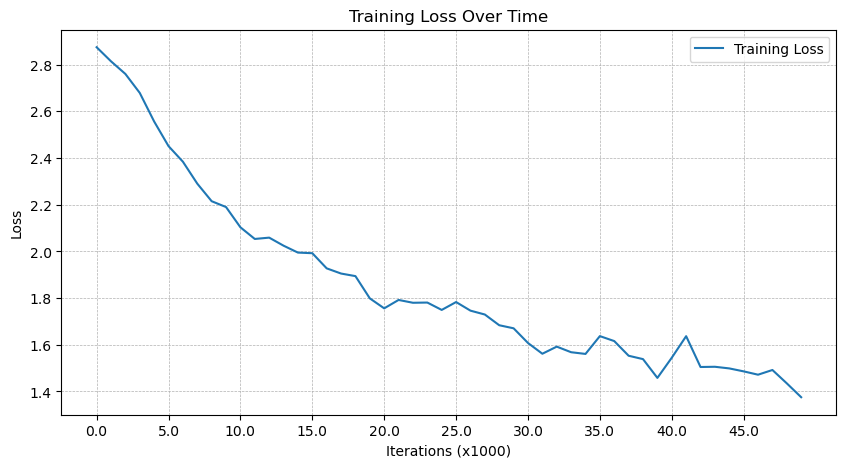

In [18]:
import matplotlib.pyplot as plt

# Prepare the plot
plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(all_losses, label='Training Loss')  # Plot the losses with a label

# Add titles and labels
plt.title('Training Loss Over Time')  # Title of the plot
plt.xlabel('Iterations (x1000)')  # X-axis label
plt.ylabel('Loss')  # Y-axis label

# Add a grid for easier reading
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend to explain which line is which
plt.legend()

# Optionally, you can also add ticks at every logging interval for better clarity
xticks = range(0, len(all_losses), 5)  # Adjust the range and steps as needed
xticklabels = [f"{x * LOG_EVERY / 1000:.1f}" for x in xticks]  # Assuming LOG_EVERY iterations per log
plt.xticks(ticks=xticks, labels=xticklabels)

# Display the plot
plt.show()


#### Training Loss Over Time

The above plot illustrates the training loss of a Recurrent Neural Network as it processes and learns from the data over time. Each point on the graph represents the average loss calculated over a set interval of iterations, providing insight into the model's learning progress throughout the training phase.

#### Observations:

- **Downward Trend**: As is typical with successful training processes, the loss consistently decreases, indicating that the model is effectively minimizing the loss function and learning from the training data.

- **Rate of Decrease**: Initially, there's a steep drop in loss, suggesting that the model is rapidly learning. As iterations continue, the rate of decrease in loss slows down. This is common because early in training, there is a lot of "low-hanging fruit" for the model to learn from. As it starts to converge to a solution, improvements are harder to come by.
  
- **Fluctuations**: Some fluctuations in the loss values are observed, which are common and represent the iterative nature of the learning process as the model navigates the loss landscape.

- **Plateaus**: Towards the later iterations, the loss reduction appears to slow down, approaching what could be a plateau. This can imply that the model is nearing its convergence point, where further training may yield diminishing returns on loss reduction.

- **Final Loss Value**: The final value of the loss can give an indication of how well the model might perform on unseen data, although it's not the only metric that should be considered. If the loss is still relatively high, it might suggest underfitting. If the training loss is low but the model performs poorly on validation data, it could be overfitting.

The plot is a valuable diagnostic tool, showing not only the effectiveness of the learning process but also highlighting areas where the learning rate, model architecture, or the data itself may need adjusting for improved performance.

### Potential Next Steps to Improve RNN Performance

After examining the training loss over time, we can consider several strategies to refine the learning process and enhance the model's predictive power.

#### Learning Rate Annealing
- **Description**: As the model approaches convergence, decreasing the learning rate can help fine-tune the adjustments to the weights, potentially leading to a better-fit model.
- **Action**: Implement a learning rate scheduler that reduces the learning rate after a certain number of epochs or when the loss plateaus.

#### Regularization
- **Description**: Regularization techniques help prevent the model from overfitting to the training data, ensuring it generalizes well to unseen data.
- **Action**: Introduce dropout layers or apply L2 weight regularization to the training process.

#### Model Complexity
- **Description**: If the model's performance has plateaued, it might be due to a lack of capacity to capture the complexity of the dataset.
- **Action**: Increase the complexity of the model by adding more layers or increasing the number of neurons in existing layers.

#### Early Stopping
- **Description**: Training for too long can lead to overfitting, and early stopping helps prevent this by terminating the training process once the model stops improving on a validation set.
- **Action**: Monitor performance on a validation set and stop training when improvement ceases for a set number of iterations.

#### Data Augmentation
- **Description**: More diverse training data can improve the model's ability to generalize and perform well on unseen data.
- **Action**: Augment the dataset by adding variations to the existing data or gathering more data if possible.

#### Validation Loss Monitoring
- **Description**: Observing the validation loss alongside the training loss offers a clearer picture of the model's generalization capabilities.
- **Action**: Plot the validation loss over time and compare it with the training loss to check for signs of overfitting.

Implementing these steps requires careful monitoring and iteration. Each change should be validated by observing its effect on both training and validation performance to ensure the model benefits from the adjustments.


To evaluate the network, we will create a confusion matrix. We can do this by going through all of the available testing examples and making note of what the network thinks is the language of that given name.

The context manager torch.no_grad can be used to disable the automatic tracking of gradients that PyTorch does. When testing the network, we do not need to keep track of the gradients because those are only needed for training. So, we disable gradient tracking inside evaluate_test.

In [19]:
def evaluate_test(rnn, name_tensor):
    """Auxiliary function to get the output from the network without training."""
    hidden = rnn.init_hidden()

    with torch.no_grad():
        for char_tensor in name_tensor:
            output, hidden = rnn(char_tensor, hidden)

    return output

In [20]:
# Empty confusion matrix:
confusion = torch.zeros(n_languages, n_languages)

# Go through all examples and see how the network does.
correct = 0
for language, names in testing.items():
    lang_idx = languages.index(language)
    for name in names:
        # Build the language and name tensors for the example.
        lang_tensor = torch.tensor(languages.index(language), dtype=torch.long)
        name_tensor = name_to_tensor(name)
        # Get the output.
        output = evaluate_test(rnn, name_tensor)
        # Interpret the output.
        _, guess_idx = language_from_output(output)
        # Mark the output in the confusion matrix.
        confusion[lang_idx][guess_idx] += 1
        # Did we guess correctly?
        correct += guess_idx == lang_idx

total_examples = sum(len(names) for names in testing.values())
print(f"Overall accuracy is {100 * correct / total_examples:.2f}%")

Overall accuracy is 51.49%


As we can see, the overall accuracy was a bit over 50%. This means that the network can recognise about half of the names correctly. Remember that we are talking about names that the network has never seen before!



/var/folders/gl/q2977b1d2f11wv63sxv4cyhh0000gn/T/ipykernel_78772/4147302400.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + languages, rotation=90)
/var/folders/gl/q2977b1d2f11wv63sxv4cyhh0000gn/T/ipykernel_78772/4147302400.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + languages)


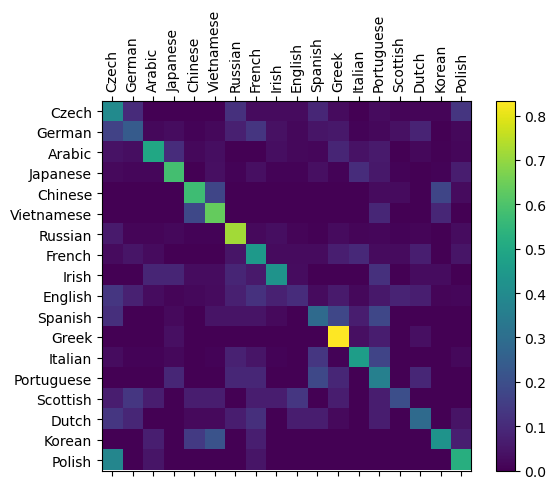

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# 'confusion' is a 2D NumPy array where the element at index (i, j)
# represents the number of times the language at true index i was predicted as the language at index j.
# Normalize the confusion matrix by dividing each row by its sum.
confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)

# Set up the matplotlib figure and axes.
fig, ax = plt.subplots()
# Create a matrix plot with the normalized confusion matrix using a colormap of your choice (e.g., 'viridis').
cax = ax.matshow(confusion_normalized, cmap='viridis')
# Add a color bar to the side of the plot, indicating the scale of the confusion matrix.
fig.colorbar(cax)

# Set the labels for the x and y axes to the names of the languages.
# The languages variable is assumed to be a list of language names.
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Use ticker.MultipleLocator to ensure a label is shown for every language.
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Display the confusion matrix plot.
plt.show()


Based on common traits found in confusion matrices:

* Diagonal Dominance: A well-performing classification model should have a confusion matrix where the majority of the predictions fall along the diagonal, indicating correct classifications. In your matrix, there are several bright squares along the diagonal, which suggests that many names were correctly classified according to their languages.

* Off-Diagonal Bright Spots: Bright squares off the diagonal indicate instances where the model consistently misclassified names from one language as another. These may point to similarities that the model is picking up on between different languages or areas where the model is particularly confused.

* Dark Squares: Darker squares, especially off the diagonal, imply fewer misclassifications. However, if dark squares appear on the diagonal, this would suggest that the model often fails to correctly classify names from that particular language.

* Column/Row Patterns: If a particular row or column is brighter compared to others, it could indicate that the model has a bias toward predicting a certain language either too frequently or not frequently enough. For example, if a column is consistently brighter, it could mean the model often falsely predicts that language for names of different actual languages.

Based on this image:

The model seems to be doing well with certain languages, as evidenced by the bright squares along the diagonal.
The model may be confusing certain languages with others, suggested by any bright squares away from the diagonal. It would be beneficial to investigate these particular cases to understand why these confusions are occurring.
Enhancements to the model or the training process, such as increasing the dataset size, diversifying the training examples, or adjusting model complexity, might improve overall accuracy and reduce confusion.
Further analysis could involve looking at specific names that were misclassified and understanding whether the errors are due to the name's linguistic features or a lack of representation in the training data.


In [22]:
print("Type names and the network classifies them.")
print("An empty name will quit.")
while name := input(" >> "):
    normalised_name = unicode_to_ascii(name.strip())
    name_tensor = name_to_tensor(normalised_name)
    output = evaluate_test(rnn, name_tensor)
    language = language_from_output(output)
    print(language)

Type names and the network classifies them.
An empty name will quit.
 >> Tanya
('Japanese', 3)
 >> Federico
('Portuguese', 13)
 >> IMing
('Chinese', 4)
 >> Hyunji
('Japanese', 3)
 >> Anastasiia
('Czech', 0)
 >> Bernadette
('Russian', 6)
 >> Siddhartha
('Japanese', 3)
 >> David
('French', 7)
 >> Tulsi
('Italian', 12)
 >> Delia
('Spanish', 10)
 >> Hsuan-Ming
('German', 1)
 >> Ryan
('Irish', 8)
 >> John
('Korean', 16)
 >> 


Thus, you may have noticed that the neural network doesn't always, well, learn. This may be occuring for a number of reasons, including inadequate weight initialization, a suboptimal learning rate, or even an insufficient number of training epochs. In some cases, the network architecture itself might not be suitable for the complexity of the data at hand.

In any case, the key takeaway here is simple: training neural networks isn't easy! Even for small, relatively simple datasets such as demonstrated, training a neural network can take some care and finesse.

### References:
    
1. https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html